# HOW TO CITE:
Karlsson, Linn (2018), _NEGI course Report: Aerosol size distributions and light scattering at Zeppelin station - comparing model and observational data, Stockholm University, linn.karlsson@aces.su.se

<font size=6> Aerosol size distributions and light scattering at Zeppelin station - comparing model and observational data</font>
<br><br>
<font size=4>
**Linn Karlsson** (linn.karlsson@aces.su.se), in collaboration with Kristine Garvin <p>
6 Nov, 2018<p>
_NeGI course 2018 - Climate science at high latitudes: Modelling and model evaluation_<p>
Group assistants: Maria and Tommaso 
</font>

# Abstract 

We compare aerosol number size distributions and dry aerosol light scattering coefficients from the Norwegian Earth System Model (NorESM) with observational data from Zeppelin station, Svalbard. While the average modelled size distribution does not look entirely unreasonable, we find that NorESM fails to accurately capture the observed size distributions on the seasonal scale. The same can be said for total aerosol number and surface concentration as well as for light scattering. We hypothesise that maybe the model overestimates the contribution of larger particles to the scattering coefficient; however, we did not have the time to properly investigate this. The aerosol particle size range in the observational data is relatively narrow - data covering a wider size range would have made the comparison to the model more straightforward and perhaps also more fair. As it stands, we can only speculate about the causes of the differences...

# Introduction

Aerosol particles affect the Earth's radiative balance both directly (through absorption and scattering) and indirectly (by acting as cloud condensation nuclei and affecting the properties of clouds). Aerosols, clouds and aerosol-cloud interactions contribute the largest uncertainties to projections of how the climate will change in the future (Boucher et al., 2013).  

During this course, we compared modelled aerosol number size distributions and light scattering to observations. Particle size and number concentrations are important to model correctly to get reasonable scattering estimates. The original plan was to attempt to do a closure study between model and measurements for different Arctic sites, by applying Mie theory calculations to the number size distribution and chemical composition data to calculate scattering coefficients (a topic suggested to us by Betsy, inspired by Alvarado et al., 2016). However, this turned out to be a difficult task that would require more time than we had, so we settled for doing a comparison using just one model and observations at one measurement site.

The model we used was the Norwegian Earth System Model (NorESM) (Bentsen et al., 2013; Iversen et al., 2013; Kirkevåg et al., 2013), because Tanja was able to give us access to an ensemble of three model runs from which we could get size distribution data (we could not get this from any of the other models). We picked Zeppelin station, Ny-Ålesund, Svalbard as the site: the observational dataset of aerosol number size distributions we used is from Freud et al. (2017), and the scattering data is from EBAS (although the files we used were provided by Peter Tunved from Stockholm University). 

Kristine Garvin and I worked on this project together. She focused on finding and reading observational data, while I focused on the model data. We then put our code into the same notebook and produced the comparison plots together. Therefore, the methods section ([3](#Methods)) is divided into parts: reading and processing observational data, reading and processing model data, and making sure the different datasets are comparable. The results and discussion section ([4](#Results-and-discussion)) is subsectioned based on the different parameters we analysed, with an additional subsection discussing the effect that the choice of model grid box (to match the observational station) might have on the results. Finally, a summary and outlook ([5](#Summary-and-outlook)) is given.

# Methods

In [1]:
# Import packages
import numpy as np
import glob
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting cosmetics
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

[Section 3.1](#Observational-data) contains the code for reading and processing the observational data, [section 3.2](#Model-data) contains the code for reading and processing the model data, and in [section 3.3](#Make-model-and-observational-data-comparable) we process the data further to make sure that they are comparable. Both the observational data and the model data had their own issues and difficulties, but I will only go into detail about the issues related to the model part since that is what I worked on.

## Observational data

Below you will find Kristine's code. 

### Extract data 

Read aerosol size distribution and light scattering data from Zeppelin station, Ny-Ålesund. The size distribution data covers particle diameters between 20 and 500 nm, and we select scattering data only for 550nm wavlength because we can get that parameter from the model data.

In [2]:
# Fetching data from NIRD
# Size distribution data
DFsd = []
path1 = '../../inputs/Aerosol_sizedist_obs/'
folder1 = glob.glob(path1+'Zeppelin*.csv')
folder1.sort()
for file in folder1:
    DFsd.append(pd.read_csv(file, sep=','))
    
# Scattering coefficient data
DFsc = []
path2 = '../../inputs/Nephelometer_ZEP_dryscattering_GOODDATA/'
folder2 = glob.glob(path2+'ZEP*.nas')
folder2.sort()
for file in folder2:
    df1 = pd.read_csv(file, sep='\s+', header=None, skiprows=96)
    DFsc.append(df1.loc[:, [0, 1, 2, 3, 9, 26]])


### Clean data

Clean data based on flags in the input files.

In [3]:
# Cleaning the size distribution data set 
# - replacing bad/missing data with NaN
for i, df in enumerate(DFsd):
    df.drop(df[df.iloc[:,-1] != 0.0].index, inplace=True)
    df.iloc[:, 0:5] = df.iloc[:, 0:5].astype(int)  
    df = df.iloc[0:, 7:-1]
    #df[df[:] == 1000.0] = np.nan
    #df[df[:] == 999.999] = np.nan
    df[df[:] < 0] = np.nan
    DFsd[i].iloc[0:, 7:-1] = df
    
# Cleaning the scattering coefficient data set
# - replacing the bad/missing data with NaN
for i, df in enumerate(DFsc):
    df.drop(df[df.iloc[:,-1] != 0].index, inplace=True)    
    df[df[:] == 1000.0] = np.nan
    df[df[:] == 0.999] = np.nan
    df[df[:] < 0] = np.nan
    df[df.iloc[:, 4] > 100] = np.nan
    DFsc[i] = df.iloc[:, [0, 2, 4]]

### Process and concatenate data

In [4]:
# Creating lists of dataframes
SD = []
for df in DFsd:
    df.rename(columns={list(df)[0]:'year', list(df)[1]:'month',
                       list(df)[2]:'day', list(df)[3]:'hour',
                       list(df)[4]:'minute'}, inplace=True)
    df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']],
                              format='%Y%m%d%H%M')
    dft = df.iloc[:, 6:-1]
    dft.columns = pd.to_numeric(dft.columns)
    SD.append(dft) # List of Size Distribution dataframes

SD = pd.concat(SD[:], sort=True)


SC = []
for i in range(len(DFsc)):
    df = DFsc[i]
    df.rename(columns={list(df)[0]:'time',
                       list(df)[1]:'year', 
                       list(df)[2]:'sc550'}, inplace=True)
    year = str(int(df.iloc[1, 1])) 
    df.index = pd.to_datetime(year+'-1-1') + pd.to_timedelta(df['time'], unit='D')
    SC.append(df.iloc[:, 2]) # List of Scattering coefficient dataframes

SC = pd.concat(SC[:], sort=True)

## Model data

This section contains a short description of the model data, as well as code, functions and a couple of explanatory figures relating to how I read and processed the data.

### Data description

We wanted to compare modelled aerosol size distributions to measurements. This turned out to be easier said than done, as most models do not output size distribution data. Luckily for us, Tanja had access to an ensemble of 3 model runs from NorESM where this information was output, so those are what we used. The files, which were in NetCDF format, were preprocessed using CDO. We picked out the Arctic region (defined arbitrarily here as everything above 70$^\circ$N, since that region encompasses all the measurement stations from where we have observational data), the two lowest vertical layers in the model and the variables we needed, using the following command:

```bash
cdo -sellonlatbox,0,360,70,90 -selvar,ABSDRYAE,ECDRYAER,N_AER,RNEWD1,RNEWD2,RNEWD4,RNEWD5,RNEWD6,RNEWD7,RNEWD8,RNEWD9,RNEWD10,NNAT_0,NNAT_1,NNAT_2,NNAT_4,NNAT_5,NNAT_6,NNAT_7,NNAT_8,NNAT_9,NNAT_10,NNAT_11,NNAT_12,NNAT_13,NNAT_14,LOGSIG1,LOGSIG2,LOGSIG4,LOGSIG5,LOGSIG6,LOGSIG7,LOGSIG8,LOGSIG9,LOGSIG10 -sellevel,970.5548,992.5561 infile.nc outfile.nc
```

where the input files `CTRL_01.nc`, `CTRL_02.nc`, `CTRL_03.nc` can be found in this directory:

```bash
 /projects/NS1000K/NEGI-Andoya/inputs/NorESM_for_sizedistr/
 ```

I named the output files `ctrl1.nc`, `ctrl2.nc`, `ctrl3.nc` and put them in my student folder:

```bash
 /projects/NS1000K/NEGI-Andoya/students/karlsson_linn/
 ```

### Load data

In [5]:
# Paths to NorESM files from Tanja, preprocessed in CDO
run1 = './ctrl1.nc'
run2 = './ctrl2.nc'
run3 = './ctrl3.nc'

I tried different packages for reading NetCDF files: `iris`, `pyaerocom` and `xarray`. I eventually settled on `xarray`, because it was the most intuitive one for me to use since it is similar to `pandas`, which I was already familiar with.

In [6]:
# Load all files together as a multifile dataset using xarray
dsmf = xr.open_mfdataset([run1, run2, run3], concat_dim='model_run')

In [7]:
# Print variables in dataset
print('Variables in the dataset:')
reshaped = np.reshape(dsmf.data_vars, (4, 10))
for row in range(reshaped.shape[0]):
    print(',  '.join(reshaped[row, :]))

Variables in the dataset:
hyai,  hybi,  hyam,  hybm,  time_bnds,  ABSDRYAE,  ECDRYAER,  LOGSIG1,  LOGSIG10,  LOGSIG2
LOGSIG4,  LOGSIG5,  LOGSIG6,  LOGSIG7,  LOGSIG8,  LOGSIG9,  NNAT_0,  NNAT_1,  NNAT_10,  NNAT_11
NNAT_12,  NNAT_13,  NNAT_14,  NNAT_2,  NNAT_4,  NNAT_5,  NNAT_6,  NNAT_7,  NNAT_8,  NNAT_9
N_AER,  RNEWD1,  RNEWD10,  RNEWD2,  RNEWD4,  RNEWD5,  RNEWD6,  RNEWD7,  RNEWD8,  RNEWD9


There are 14 different aerosol "modes" in NorESM. The modes are related both to typical size modes (nucleation, Aitken, accumulation and coarse mode) and chemical components (sulphate, black carbon, particulate organic matter, mineral dust and sea salt), but not all chemical components exist in all size modes within NorESM, and particles can be internally mixed. The result is these 13 so-called modes. They are numbered from 0 to 14, but number 3 is missing (unclear why). Each mode has a mean particle diameter $\mu$ and a standard deviation $\sigma$. These parameters, together with the number concentration, can be used to generate number size distributions for the different aerosol modes (see [section 1.1.3.1](#Define-the-lognormal-distribution)). The model output that we will use is the following:

* NNAT_[0-14] - aerosol particle number concentration for the different modes
* LOGSIG[1-10] - standard deviation for some of the modes (the others have constant values, see below)
* RNEWD[1-10] - dry particle diameter for some of the modes (the others have constant values, see below)
* ABSDRYAE - dry aerosol absorption coefficient at 550 nm
* ECDRYAER - dry aerosol extinction coefficient at 550 nm

Modes 0, 11, 12, 13, 14 do not have output for the dry diameters and standard deviations, so we have to specify those from the prescribed values in NorESM.

#### Dealing with the "missing" output streams (the prescribed/constant values)

In [8]:
# Some definitions from Tanja's code of the prescribed values
# (values that are constant for some modes)
# Dry diameters in µm
rdry = [0.1, 0.0118, 0.0118, 0.04, 0.075, 0.22, 0.63,
        0.022, 0.13, 0.74, 0.0118, 0.0118, 0.04, 0.04]
# Standard deviations
psig  = [1.6, 1.8, 1.8, 1.8, 1.59, 1.59, 2.00,
         1.59, 1.59, 2.00, 1.8, 1.8, 1.8, 1.8] 
# Logarithm of standard deviations, which is what is used in 
# the formula (and what the model outputs in LOGSIG)
logsig = np.log10(psig)

For simplicity, I want to create the missing variables in my `xarray` dataset so that I can just use `xarray` functions for dealing with everything. This turns out to be much slower than using `numpy` (like Tanja), but since we're only interested in point data and do not need to generate size distributions for every gridbox in the NorESM output, I will stick to using `xarray` because the labelling functionality makes it easier for me to keep track of the variables and what I'm doing. Also, the `xarray` package makes plotting quite convenient (similar to `pandas`).

In [9]:
# Put the missing variables into the dataset (prescribed values)

# Missing variables and the corresponding indices
# (mode-1 for mode>2 because mode 3 is missing)
LOGSIG_missing = [('LOGSIG0', 0), ('LOGSIG11', 10),
                  ('LOGSIG12', 11), ('LOGSIG13', 12),
                  ('LOGSIG14', 13)]

RNEWD_missing = [('RNEWD0', 0), ('RNEWD11', 10),
                 ('RNEWD12', 11), ('RNEWD13', 12), 
                 ('RNEWD14', 13)]

# # Loop over the missing variables, create new ones in the dataset, and assign correct values
for (name, index) in LOGSIG_missing:
    # Copy and rename a variable (to get right dimensions), and merge it with original dataset
    # NB! Need to make a copy in each loop, to avoid the variables occupying the same memory space
    dsmf = xr.merge([dsmf, dsmf['LOGSIG1'].copy().rename(name)])
    # Assign prescribed values to the new variable
    dsmf[name].values[:] = logsig[index]

for (name, index) in RNEWD_missing:
    # Copy and rename a variable (to get right dimensions), and merge it with original dataset
    # NB! Need to make a copy in each loop, to avoid the variables occupying the same memory space
    dsmf = xr.merge([dsmf, dsmf['RNEWD1'].copy().rename(name)])
    # Assign prescribed values to the new variable
    dsmf[name].values[:] = rdry[index]

### Generate size distributions 

#### Define the lognormal distribution

The lognormal size distribution has the following equation:

$$\frac{dN_i}{d\log{D_p}} = \frac{N_{tot,i}}{\sqrt{2\pi}}\frac{1}{\log{\sigma_i}}\exp{(-\frac{\log^2{(\frac{D_p}{\mu_i})}}{2\log^2(\sigma_i)})}$$

where $D_p$ is dry particle diameter and $N_{tot,i}$, $\mu_i$ and $\sigma_i$ are the total aerosol number concentration, mean modal diameter and standard deviation of mode $i$, respectively. Below, we define the `lognormal` function that takes these inputs and returns $\frac{dN_i}{d\log{D_p}}$ .

In [10]:
def lognormal(x, N, mu, logsigma):
    '''Function that defines the lognormal distribution.
    
    Parameters:
        x        :   (np.array) The particle diameters (in micrometres) at which you wan to evaluate dN/dlogD
        N        :   The number concentration in this particular aerosol mode (MODEL OUTPUT)
        mu       :   The mean modal radius (NB!) (MODEL OUTPUT)
        logsigma :   The logarithm of the standard deviation of this mode (MODEL OUTPUT)
        
    Returns an array of the same size as x, with dNdlogD values.'''
    return N * (1/np.sqrt(2*np.pi)) * (1/logsigma) * np.exp(-np.log10(x/(2*mu))**2 / (2 * logsigma**2))

#### Pick out a station and particle diameters

The observational data that is read in Kristine's code ([section 2.1](#Observational-data)) is from Zeppelin station in Ny-Ålesund, Svalbard. The geographical coordinates of this station are 78°54’ N, 11°52’ E, and it is located 474
metres above sea level. We select the lowest vertical layer in the model (see [section 4.3](#Choice-of-model-grid-box)) for comparison of different grid cells) in the grid box closest to those coordinates.

In [11]:
# Pick out the station
# Lat, lon in decimal form
station_lat = 78.9
station_lon = 11.9
# Pressure of lowest vertical layer
station_lev = 992

# Pick out the nearest neighbour grid cell to match the above coordinates
station = dsmf.sel(lon=station_lon,
                   lat=station_lat,
                   lev=station_lev,
                   method='nearest')

To calculate $\frac{dN_i}{d\log{D_p}}$, we need to provide the `lognormal` function with some input diameters. Below, I define two different diameter arrays: one that is equidistant in logarithmic space and covers the entire model aerosol particle size range (up to 15 µm), and one that is the same as the diameters in the observational data (20 to 502 nm in 29 steps).

In [12]:
# Choose diameters (in µm) for which we want to calculate dNdlogD
# Diameters than span the entire NorESM size range (10nm to 15µm)
x = np.geomspace(start=0.001, stop=15, num=50)
# Same diameters as in the observational data
x_obs = SD.columns*1e-3

####  Calculate size distributions from the model data

I define the following functions to be able to apply the `lognormal` function to the dataset where the station is picked out. They are quite slow to execute -- I am not entirely sure why, maybe I wrote inefficient code or it has something to do with the way the `xarray` dataset is structured (the `dask` array functionality might make it so it reads/writes to disk instead of in memory?). If I read in the NetCDF files separately and then apply the `generate_size_distribution` function to each one, that is much faster. However, reading the model output as a multifile dataset is convenient for plotting later, so I will just accept that my code is slow.

In [13]:
def generate_size_distribution(station_ds, diameter_array):
    '''Function that uses the data from the input dataset (NB! needs to be one gridbox, i.e. the 
    station location should already be picked out) to generate number size distributions for all
    aerosol modes for the diameters specified in the input.
    
    Parameters
        station_ds : xarray DataSet with all necessary variables, but reduced to one gridbox (e.g. Zeppelin)
        diameter_array : numpy array with the diameters (in µm) at which you want dNdlogD to be calculated
        
    Returns an xarray DataArray with dimensions modes (the different aerosol modes in NorESM),
    time (the timesteps from the input dataset), and diameter (the input diameters).
    '''
    # Make a list of the modes
    modes = ['MODE_'+str(num) for num in range(15)]
    modes.pop(3); # remove mode 3 because it doesn't exist

    # Make 3D numpy array with zeros and the right shape
    zerodata = np.zeros([len(modes), len(station_ds.time.values), len(diameter_array)], float)

    # Make xarray DataArray with the correct dimension, filled with zeros
    dndlogd = xr.DataArray(zerodata, dims=('mode', 'time', 'diameter'),
                           coords={'mode': modes, 'time': station_ds.time.values,
                                   'diameter': diameter_array})

    # Loop over the different modes and timesteps and fill our DataArray with dNdlogD data
    for i, mode in enumerate(dndlogd.mode.values):
        # Pick out the mode number to use for indexing the dataarray
        n = mode.split('_')[1]
        for j, time in enumerate(dndlogd.time.values):
            # Fill the output dataarray with calculated dNdlogD values
            dndlogd.loc[mode, time, :] = lognormal(dndlogd.diameter.values,
                                                   station_ds['NNAT_'+n].values[j],
                                                   station_ds['RNEWD'+n].values[j],
                                                   station_ds['LOGSIG'+n].values[j])
    return dndlogd

In [14]:
def generate_SD_across_ensemble(station_ds, diameter_array):
    '''Function that uses the generate_size_distribution function on each run and returns
    a dataset with the run as an extra dimension (similar to the original multifile dataset).'''
    r0 = generate_size_distribution(station_ds.sel(model_run=0), diameter_array)
    r1 = generate_size_distribution(station_ds.sel(model_run=1), diameter_array)
    r2 = generate_size_distribution(station_ds.sel(model_run=2), diameter_array)
    
    return xr.concat([r0, r1, r2], dim='model_run')

In [15]:
# Generate size distributions for all model runs and all modes for the selected station
# Using diameter array covering the full particle size range
dndlogd_fullrange = generate_SD_across_ensemble(station_ds=station, diameter_array=x)
# Using diameter array covering a smaller size range (the same as the observational data)
dndlogd_smallrange = generate_SD_across_ensemble(station_ds=station, diameter_array=x_obs)

What you get out from these calculations are the size distributions for each of the 14 "modes" in NorESM. To get the full aerosol size distribution, you simply sum up the different modes (see Fig. 1 below).

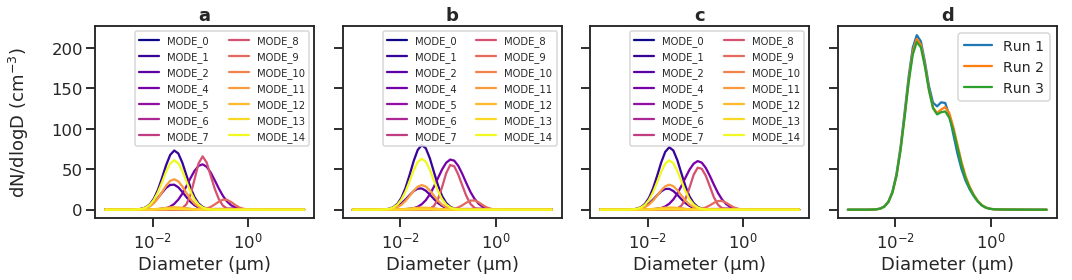

In [16]:
# Figure 1
fig, ax = plt.subplots(ncols=4, figsize=(15, 4), sharex=True, sharey=True)

# Create a colour thing to use for nice gradient
# Number of colours needed
nn = len(dndlogd_fullrange.mode.values)
# Colourmap of choice
cc = plt.cm.get_cmap('plasma', nn)

for i, axis in enumerate(ax[:3]):
    for j, mode in enumerate(dndlogd_fullrange.mode.values):
        # Select model run, plot current mode in colour number j
        dndlogd_fullrange.sel(model_run=i).loc[mode].mean(dim='time').plot(label=mode, ax=axis, c=cc(j/nn))
        # Set the x-axis to log scale
        plt.xscale('log')

# Put a y-axis label
ax[0].set_ylabel('dN/dlogD (cm$^{-3}$)', labelpad=20)
# Put titles, x-axis labels, and legends
for i, axis in enumerate(ax[:3]):
    axis.set_xlabel('Diameter (µm)')
    axis.legend(fontsize=10, ncol=2)

# Plot the fourth panel separately because it is different
for i in range(len(dndlogd_fullrange.model_run)):
    # Sum all modes and plot for each model run
    dndlogd_fullrange.sum(dim='mode').sel(model_run=i).mean(dim='time').plot(label='Run '+str(i+1), ax=ax[3])
    # Set the x-axis to log scale
    plt.xscale('log')
# Make legend, label, title for fourth panel
ax[3].legend(fontsize=14)
ax[3].set_xlabel('Diameter (µm)')

# Make letter titles
for panel, letter in enumerate(['a', 'b', 'c', 'd']):
    ax[panel].set_title(letter, fontweight='bold')

plt.tight_layout()
plt.show()

<center><font size=3> <b>Fig. 1: a,b,c</b> show the number size distribution for all 14 aerosol particle modes in NorESM in model runs 1, 2 and 3, respectively. <br><b>d</b> shows the summed up, final number size distribution for each of the model runs.  </font> </center>

##### Sanity check - does the integrated number size distribution match the model output total number concentration?

Just to double check that the size distributions that I calculated from the model output are reasonable, I have plotted the number concentration that you get when you integrate those size distributions, together with the model output total number concentration, in Fig. 2 below. We see that the two lines coincide and the integrated value is the same as the output value, thus comfirming that the calculated number size distributions are reasonable.

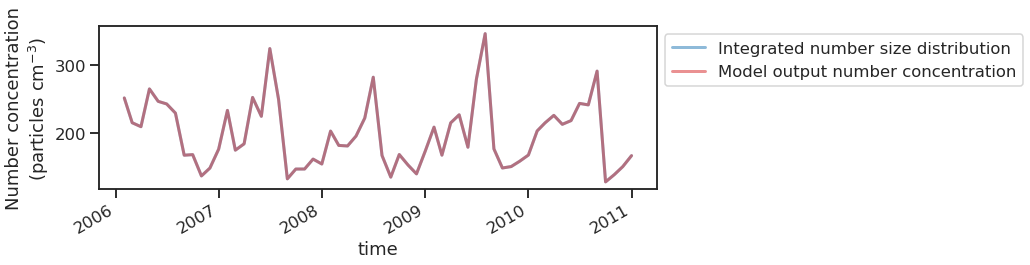

In [17]:
# Figure 2
plt.figure(figsize=(10, 3))

# Calculate integrated number concentration
N_integrated = np.trapz(dndlogd_fullrange.mean(dim='model_run').sum(dim='mode'), x=np.log10(x))

# Plot the two number concentrations
plt.plot(dndlogd_fullrange.time, N_integrated, label='Integrated number size distribution', c='C0', alpha=0.5, lw=3)
station.N_AER.mean(dim='model_run').plot(label='Model output number concentration', c='C3', alpha=0.5, lw=3)

# Labels and legend
plt.ylabel('Number concentration\n(particles cm$^{-3}$)')
plt.title(' ')
plt.legend(bbox_to_anchor=(1, 1))

plt.show()

<center><font size=3> <b>Fig. 2:</b> Comparison of model output total number concentration (in red) and the number concentration obtained by integrating the calculated number size distributions (in blue). The line appears purple because the two lines are on top of each other (i.e. the number concentrations agree).  </font> </center>

### Calculate scattering coefficient

The model does not directly output the aerosol light scattering coefficient. It does, however, output both the extinciton and absorption coefficient ($\sigma_{ext}$ and $\sigma_{abs}$), which is all we need to calculate the scattering coefficient $\sigma_{scat}$:

$$\sigma_{scat} = \sigma_{ext} - \sigma_{abs}$$

In [18]:
# Calculate scattering as extinction minus absorption
DRYSCAT = station.ECDRYAER - station.ABSDRYAE

## Make model and observational data comparable

In order to compare the observational data with the model data, we want to make sure that the data have the same units, time resolution, et cetera. 

First, we multiply the diameter values in the model datasets with $10^3$ to go from micrometres to nanometres (the DataFrame with the observational data has the diameters in nanometres).

In [19]:
# Change diameters in model data from µm to nm to match observational data
dndlogd_fullrange['diameter'] = dndlogd_fullrange.diameter*1e3
dndlogd_smallrange['diameter'] = dndlogd_smallrange.diameter*1e3

Since the total number size distribution is what is measured at Ny-Ålesund, we have no reason to keep all the 14 different "modes" that NorESM uses to describe the aerosol population. Therefore, we sum the modes up to get the final size distribution that we can compare to observational data.

In [20]:
# Sum the 14 modes to make the full size distribution to compare to measurements
dndlogd = dndlogd_smallrange.sum(dim='mode')
dndlogd_full = dndlogd_fullrange.sum(dim='mode')

The model only outputs monthly mean values. To make the comparison fair, we therefore make monthly averages out of the observational data.

In [21]:
# Resample observational data to monthly means (since the model outputs monthly means)
# (save originals for discussion of averaging methods etc)
SD_original = SD.copy()
# Resampling
SD = SD.resample('M').mean()
SC = SC.resample('M').mean()

Finally, we put the observational data into `xarray` DataArrays instead of `pandas` DataFrames, just so that all the plotting commands will be consistent and it will be easier to make sure that statistics are calculated in the same way.

In [22]:
# Convert observational data to xarray format
SD = xr.DataArray(SD, dims=['time', 'diameter'])
SC = xr.DataArray(SC, dims=['time'])

# Results and discussion

As mentioned briefly in [section 2.2.3.2](#Pick-out-a-station-and-particle-diameters), the model and observational data cover different aerosol particle size ranges. The model includes particles from a few nanometres up to 15 micrometres in size, whereas the observational data covers the size range 20 to 502 nanometres. Fig. 3 below illustrates this difference. For the majority of the results section, we will constrain our analysis to the size range from the observations (grey shaded area in the figure).

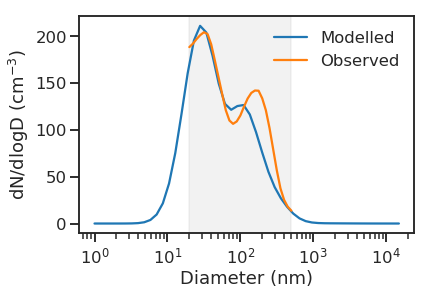

In [23]:
# Figure 3
plt.figure(figsize=(6, 4))

dndlogd_fullrange.sum(dim='mode').mean(dim=['time', 'model_run']).plot(label='Modelled')
SD.mean(dim='time').plot(label='Observed')
plt.axvspan(20, 502, color='grey', alpha=0.1)
plt.xscale('log')
plt.xlabel('Diameter (nm)')
plt.ylabel('dN/dlogD (cm$^{-3}$)')

plt.legend(frameon=False)
plt.show()

<center><font size=3> <b>Fig. 3:</b> Illustration of the different particle size ranges covered by the model (blue) versus the observational data (orange). The shaded grey area indicates the size range in the observations, and the coloured lines are the mean values of both datasets.  </font> </center>

## Number size distribution and concentration

Fig. 4 below shows how the modelled and measured number size distributions compare. We show both mean (Fig. 4a) and median (Fig. 4b) values, because there is an interesting point to be made - how "good" the agreement between models and observations is can depend on which statistic you look at! The mean looks a lot better than the median, especially at the smaller end of the size range. For the remainder of the analysis we have looked only at mean values ($\pm$ standard deviations), for two reasons: 1) both observational and model data had already been averaged, so it seemed consistent to stick with the mean, and 2) it was programmatically easier. If we had had more time to figure out how to deal with medians across all relevant data dimensions in `xarray`, we would have compared the two in more detail.

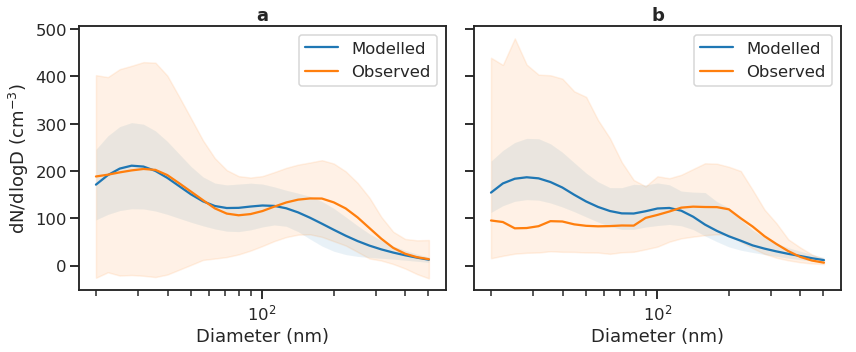

In [45]:
# Figure 4
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)

# # ======== MEAN +- STD ========= # #
# Model data
# Calculate mean and standard deviation across the ensembles and over all time steps
model_mean = dndlogd.mean(dim=['model_run', 'time'])
model_std = dndlogd.std(dim=['model_run', 'time'])

# Plot model mean
model_mean.plot(label='Modelled', ax=ax[0])
ax[0].fill_between(model_mean.diameter, model_mean + model_std, model_mean - model_std, alpha=0.1)

# Observational data
# Calculate mean and standard deviation over all time steps
obs_mean = SD.mean(dim='time')
obs_std = SD.std(dim='time')

# Plot observed mean
ax[0].semilogx(obs_mean.diameter, obs_mean.values, label='Observed')
ax[0].fill_between(obs_mean.diameter, obs_mean + obs_std, obs_mean - obs_std, alpha=0.1, color='C1')

# Labels
ax[0].set_ylabel('dN/dlogD (cm$^{-3}$)')
ax[0].set_xlabel('Diameter (nm)')
ax[0].set_title('a', fontweight='bold')

# # ======= MEDIAN with 75th & 25th percentiles ======= # #
# Model data
# Calculate medians and percentiles (per diameter) across entire dataset
model_median = dndlogd.median(dim=['model_run', 'time'])
model_75th = dndlogd.quantile(.84, dim=['model_run', 'time'])
model_25th = dndlogd.quantile(.16, dim=['model_run', 'time'])

# Plot model median
model_median.plot(label='Modelled', ax=ax[1])
ax[1].fill_between(model_median.diameter, model_75th, model_25th, alpha=0.1)

# Observational data
# Calculate medians and percentiles (per diameter) across entire dataset
obs_median = SD.median(dim='time')
obs_75th = SD.quantile(.84, dim='time')
obs_25th = SD.quantile(.16, dim='time')

# Plot observed median
ax[1].semilogx(obs_median.diameter, obs_median.values, label='Observed')
ax[1].fill_between(obs_median.diameter, obs_75th, obs_25th, alpha=0.1, color='C1')

# Labels
ax[1].set_xlabel('Diameter (nm)')
ax[1].set_title('b', fontweight='bold')


# Legends
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

<center><font size=3> <b>Fig. 4: a</b> shows mean modelled (blue) and observed (orange) aerosol number size distributions; shaded areas show the mean $\pm$ standard deviation. <b>b</b> shows median modelled and observed aerosol number size distributions; shaded areas indicate the 84th and 16th percentiles. </font> </center>

Fig. 5 below shows the same thing as Fig. 4a, but split up by season. In winter (DJF) and autumn (SON), the model overestimates the number of small aerosol particles, while it underestimates them in summer (JJA). The model underestimates the concentration of the larger size mode in winter and spring (MAM). In other words, NorESM fails to capture both new particle formation (small particles nucleated from oxidised vapours in summer) and Arctic haze (larger particles transported from lower latitudes in spring). We can clearly see that what looked like a good agreement in the overall mean, is not actually very good in the seasonal means. Perhaps there are different effects that cancel each other out? I do not know how models are generally tuned to match observed aerosol populations, but I can imagine that it is easier to tune the model to accurately represent bulk properties like "annual average size distribution" or "total number concentration" than it is to model precisely which sizes of particles play which roles in the atmosphere and during which season.

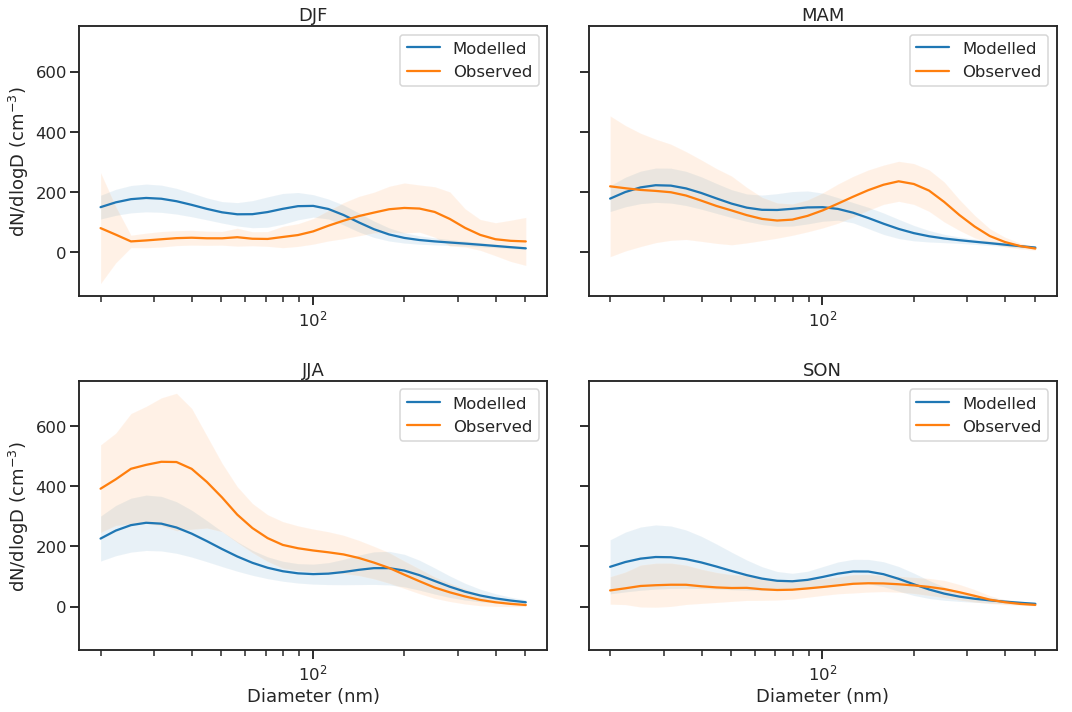

In [25]:
# Figure 5
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)

# Season names
ss = ['DJF', 'MAM', 'JJA', 'SON']

# Calculate mean and standard deviation per season
# Model
model_seasmean = dndlogd.groupby('time.season').mean(dim=['time', 'model_run'])
model_seasstd = dndlogd.groupby('time.season').std(dim=['time', 'model_run'])
# Observations
obs_seasmean = SD.groupby('time.season').mean(dim='time')
obs_seasstd = SD.groupby('time.season').std(dim='time')

# Loop
for i, axis in enumerate(ax.flatten()):
    model_seasmean.sel(season=ss[i]).plot(ax=axis, label='Modelled')
    axis.fill_between(model_seasmean.diameter, model_seasmean.sel(season=ss[i]) + model_seasstd.sel(season=ss[i]),
                      model_seasmean.sel(season=ss[i]) - model_seasstd.sel(season=ss[i]), alpha=0.1)
    obs_seasmean.sel(season=ss[i]).plot(ax=axis, label='Observed')
    axis.fill_between(obs_seasmean.diameter, obs_seasmean.sel(season=ss[i]) + obs_seasstd.sel(season=ss[i]),
                      obs_seasmean.sel(season=ss[i]) - obs_seasstd.sel(season=ss[i]), alpha=0.1)

    axis.legend()
    axis.set_xscale('log')
    axis.set_title(ss[i])
    axis.set_xlabel('Diameter (nm)')
    axis.set_ylabel('dN/dlogD (cm$^{-3}$)')

ax[0, 0].set_xlabel(' ')
ax[0, 1].set_xlabel(' ')
ax[0, 1].set_ylabel(' ')
ax[1, 1].set_ylabel(' ')

plt.tight_layout()
plt.show()

<center><font size=3> <b>Fig. 5: </b> Modelled (blue) and observed (orange) mean aerosol number size distributions by season (DJF: winter, MAM: spring, JJA: summer, SON: autumn). </font> </center>

The climatology of the total aerosol number concentration in our size range (20 - 500nm), derived by integrating the modelled and observed number size distributions, is shown in Fig. 6. The discrepancies that were apparent in Fig. 5 can also be seen here: the model overestimates the number concentration in autumn and winter, and underestimates it in spring and summer. There is perhaps a hint of a maximum in the model concentrations towards the end of summer, but overall there is little variation and the model does not capture the observed seasonality at all. Including the full modelled particle size range (dashed line in Fig. 6) makes no difference in terms of seasonality - the model still does not compare well to observations.

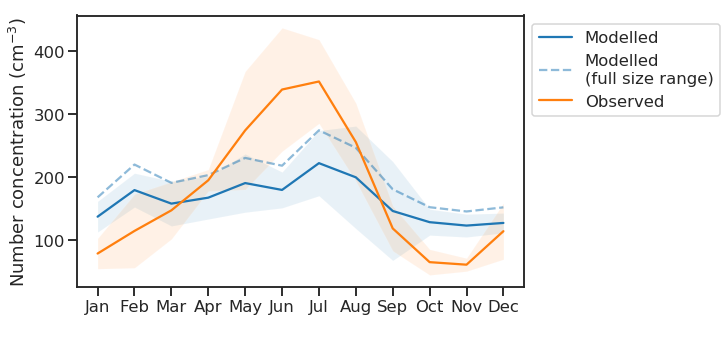

In [26]:
# Figure 6
plt.figure(figsize=(8, 5))

# Integrate size distributions to get "total" number concentration (particles between 20-500 nm)
N_int_model = xr.DataArray(np.trapz(dndlogd, x=np.log10(dndlogd.diameter)),
                           dims=['model_run', 'time'], 
                           coords={'time': dndlogd.time})
N_int_full = xr.DataArray(np.trapz(dndlogd_full, x=np.log10(dndlogd_full.diameter)),
                           dims=['model_run', 'time'], 
                           coords={'time': dndlogd_full.time})
N_int_obs = xr.DataArray(np.trapz(SD, x=np.log10(SD.diameter)),
                           dims=['time'], 
                           coords={'time': SD.time})

# Group by month (to be able to calculate mean and std for plotting climatology)
model_gb = N_int_model.groupby('time.month')
full_gb = N_int_full.groupby('time.month')
obs_gb = N_int_obs.groupby('time.month')

# Plot model data
model_gb.mean().plot(label='Modelled')
plt.fill_between(model_gb.mean().month, model_gb.mean() + model_gb.std(), model_gb.mean() - model_gb.std(), alpha=0.1)
# Plot model full range integrated
full_gb.mean().plot(label='Modelled\n(full size range)', linestyle='--', c='C0', alpha=0.5)
# Plot observational data
obs_gb.mean().plot(label='Observed')
plt.fill_between(obs_gb.mean().month, obs_gb.mean() + obs_gb.std(), obs_gb.mean() - obs_gb.std(), alpha=0.1)

# Labels etc
plt.legend(bbox_to_anchor=[1, 1])
plt.ylabel('Number concentration (cm$^{-3}$)')
plt.xlabel(' ')

plt.xticks(np.arange(1, 13, 1))
plt.gca().set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

<center><font size=3> <b>Fig. 6: </b> Climatology of modelled (blue) and observed (orange) aerosol number concentration in the size range 20 - 500nm, calculated by integrating the number size distributions. Shaded areas show the standard deviations. </font> </center>

## Surface concentration and scattering

Fig. 7a shows the seasonal cycle of modelled and observed aerosol surface concentration (obtained by converting the number size distributions into surface size distributions and then integrating over particle size). Again, the model does not really capture the seasonal cycle of the observational data. Including the full modelled aerosol particle size range gives a slightly better agreement in spring, but makes it worse during summer.

Fig. 7b shows the seasonal cycle of modelled and observed dry aerosol light scattering at 550 nm wavelength. The scattering coefficient is related to the aerosol surface -- more surface area can scatter more light. Thus, we would expect to see a similar seasonal behaviour in the surface concentration and the scattering. This seems to be true for the observational dataset: the observed surface concentration seasonality correlates well with the observed scattering seasonality, despite the relatively narrow particle size range (the scattering measurements are based on particles of all sizes). The same type of correlation can be seen between the modelled scattering and the modelled surface concentration that is based on the _full_ areosol size range in NorESM. Note that the seasonal cycles look less similar if we only consider the surface in the 20 - 500nm size range for the model data! This suggests that particles outside of the 20 - 500nm size range contribute significantly to the aerosol light scattering in NorESM. 

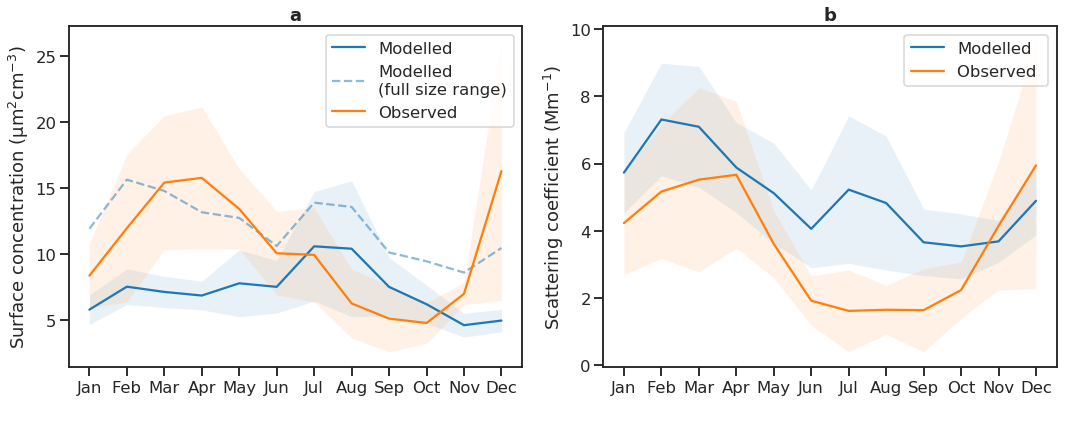

In [55]:
# Figure 7
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Calculate surface distributions
dsdlogd = dndlogd * (dndlogd.diameter*1e-3)**2 * np.pi
dsdlogd_full = dndlogd_fullrange.sum(dim='mode') * (dndlogd_fullrange.sum(dim='mode').diameter*1e-3)**2 * np.pi
SD_surface = SD * (SD.diameter*1e-3)**2 * np.pi

# Integrate size distributions to get "total" surface concentration
S_int_model = xr.DataArray(np.trapz(dsdlogd, x=np.log10(dsdlogd.diameter)),
                           dims=['model_run', 'time'], 
                           coords={'time': dsdlogd.time})
S_int_full = xr.DataArray(np.trapz(dsdlogd_full, x=np.log10(dsdlogd_full.diameter)),
                           dims=['model_run', 'time'], 
                           coords={'time': dsdlogd_full.time})

S_int_obs = xr.DataArray(np.trapz(SD_surface, x=np.log10(x_obs)),
                           dims=['time'], 
                           coords={'time': SD_surface.time})

# Group by month (to be able to calculate mean and std for plotting climatology)
model_gb = S_int_model.groupby('time.month')
full_gb = S_int_full.groupby('time.month')
obs_gb = S_int_obs.groupby('time.month')

# # ========= SUBPLOT 1 ========== # #
# Plot model data
model_gb.mean().plot(label='Modelled', ax=ax[0])
ax[0].fill_between(model_gb.mean().month, model_gb.mean() + model_gb.std(), model_gb.mean() - model_gb.std(), alpha=0.1)
# Plot model full range integrated
full_gb.mean().plot(label='Modelled\n(full size range)', ax=ax[0], linestyle='--', c='C0', alpha=0.5)
# Plot observational data
obs_gb.mean().plot(label='Observed', ax=ax[0])
ax[0].fill_between(obs_gb.mean().month, obs_gb.mean() + obs_gb.std(), obs_gb.mean() - obs_gb.std(), alpha=0.1)


# Labels etc
ax[0].legend()
ax[0].set_ylabel('Surface concentration (µm$^2$cm$^{-3}$)')
ax[0].set_title('$\mathbf{a}$')

ax[0].set_xticks(np.arange(1, 13, 1))
ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[0].set_xlabel(' ')

# # ========= SUBPLOT 2 ========== # #

model_gb = (DRYSCAT*1e6).groupby('time.month')
obs_gb = SC.groupby('time.month')

model_gb.mean().plot(label='Modelled', ax=ax[1])
ax[1].fill_between(model_gb.mean().month, model_gb.mean() + model_gb.std(), model_gb.mean() - model_gb.std(), alpha=0.1)

obs_gb.mean().plot(label='Observed ', ax=ax[1])
ax[1].fill_between(obs_gb.mean().month, obs_gb.mean() + obs_gb.std(), obs_gb.mean() - obs_gb.std(), alpha=0.1)

ax[1].legend()
ax[1].set_ylabel('Scattering coefficient (Mm$^{-1}$)')
ax[1].set_title('$\mathbf{b}$')

ax[1].set_xticks(np.arange(1, 13, 1))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[1].set_xlabel(' ')

plt.tight_layout()
plt.show()

<center><font size=3> <b>Fig. 7: a </b> shows the climatology of modelled (blue) and observed (orange) aerosol surface concentration in the size range 20 - 500nm, calculated by integrating the surface size distributions. The dashed line is the integrated surface concentration for the full modelled aerosol size range. <b>b</b> shows the climatology of modelled (blue) and observed (orange) dry aerosol light scattering at 550 nm wavelength. Shaded areas in both panels indicate the standard deviations.</font> </center>

Fig. 8 (below) shows a comparison of the mean modelled and observed number and surface size distributions. The model underestimates surface contribution of particles between 100nm - 1µm, but the surface distribution has another, larger mode that also contributes (as suspected based on Fig. 7). Unforturnately, we do not have any observational data in that size range, so we cannot say that large particles do not contribute as much in "reality". If we had the time, it would have been interesting to do Mie calculations on the observational data to know how much of the total scattering is from particles in the 20 to 500 nm range to be able to infer how much larger particles contribute.

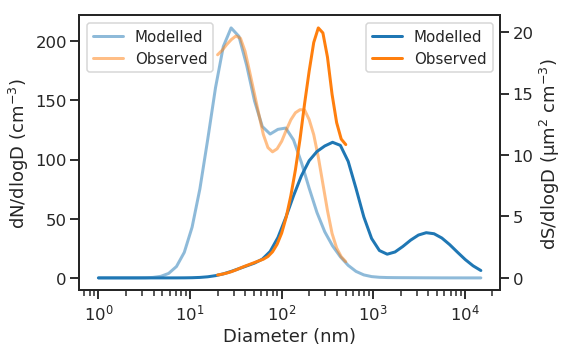

In [41]:
# Figure 8
plt.figure(figsize=(8, 5))

dndlogd_fullrange.sum(dim='mode').mean(dim=['model_run', 'time']).plot(c='C0', label='Modelled', lw=3, alpha=0.5)
SD.mean(dim=['time']).plot(c='C1', label='Observed', lw=3, alpha=0.5)
plt.ylabel('dN/dlogD (cm$^{-3}$)')
plt.legend(loc='upper left', fontsize=15)
plt.xlabel('Diameter (nm)')

y = plt.gca().twinx()
dsdlogd_full.mean(dim=['model_run', 'time']).plot(ax=y, c='C0', label='Modelled', lw=3)
SD_surface.mean(dim=['time']).plot(ax=y, c='C1', label='Observed', lw=3)
y.set_ylabel('dS/dlogD (µm$^2$ cm$^{-3}$)')

y.legend(loc='upper right', fontsize=15)

plt.xscale('log')
plt.xlabel('Diameter (nm)')

plt.tight_layout()
plt.show()

<center><font size=3> <b>Fig. 8: </b> Mean modelled (blue) and observed (orange) number size distributions (faded colours, left y-axis) and surface size distributions (full colours, right y-axis). </font> </center>

## Choice of model grid box

Comparing model and measurements is not entirely straight-forward. The observations are made at a single station, which would be a small point within a large model grid box. In our analysis, we picked out the grid box using the "nearest neighbour" method; that is, we picked the grid box whose coordinates were closest to that of the station. An alternative would have been to interpolate between grid boxes, but we did not have the time to test what difference that would make. Fig. 9 shows a quick test where we compare the mean number and surface size distributions in the chosen grid box and three neighbouring boxes (to the left, right, and above). There are some differences, but it does not seem like the neighbouring grid boxes would have fit the observations any better. It would have been interesting, had we had the time, to investigate whether the choice of grid box would have a larger impact if you compare seasonal climatologies. 

In [30]:
# Pick out the station
station_lat = 78.9
station_lon = 11.6
station_left = 10
station_right = 15
lev_sfc = 992
lev_alt = 970

station_sfc = dsmf.sel(lon=station_lon, lat=station_lat, lev=lev_sfc, method='nearest')
station_alt = dsmf.sel(lon=station_lon, lat=station_lat, lev=lev_alt, method='nearest')
station_left = dsmf.sel(lon=station_left, lat=station_lat, lev=lev_sfc, method='nearest')
station_right = dsmf.sel(lon=station_right, lat=station_lat, lev=lev_sfc, method='nearest')


In [31]:
# Choose diameters (in µm) for which we want to calculate dNdlogD
x = np.geomspace(start=0.001, stop=15, num=50)

In [32]:
# Calculate size distributions for the selected alternative grid boxes
dndlogd_sfc = generate_SD_across_ensemble(station_sfc, x)
dndlogd_alt = generate_SD_across_ensemble(station_alt, x)
dndlogd_left = generate_SD_across_ensemble(station_left, x)
dndlogd_right = generate_SD_across_ensemble(station_right, x)

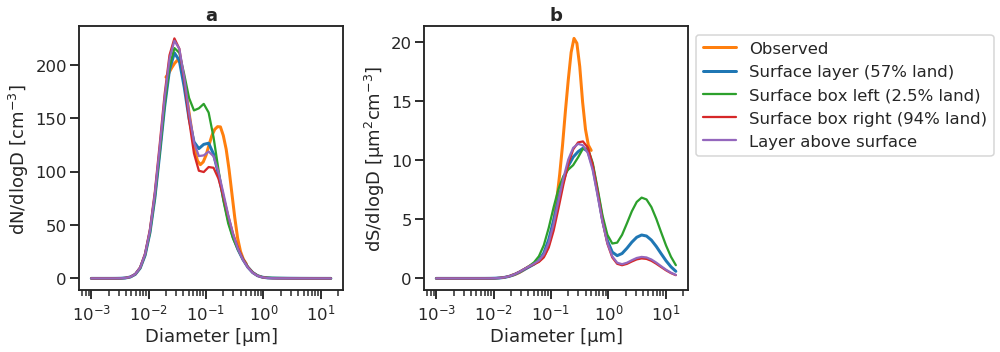

In [53]:
# Figure
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
ax[0].plot(SD.diameter*1e-3, SD.mean(dim='time').values, label='Observed', c='C1', linestyle='-', lw=3)
dndlogd_sfc.mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Surface layer (57% land)', ax=ax[0], c='C0', lw=3)
dndlogd_left.mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Surface box left (2.5% land)', ax=ax[0], c='C2')
dndlogd_right.mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Surface box right (94% land)', ax=ax[0], c='C3')
dndlogd_alt.mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Layer above surface', ax=ax[0], c='C4')
ax[0].set_xscale('log')
ax[0].set_xlabel('Diameter [µm]')
ax[0].set_title('$\mathbf{a}$')
ax[0].set_ylabel('dN/dlogD [cm$^{-3}$]')


ax[1].plot(SD.diameter*1e-3, (SD * (SD.diameter*1e-3)**2 * np.pi).mean(dim='time').values, label='Observed', c='C1', linestyle='-', lw=3)
(dndlogd_sfc * x**2 * np.pi).mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Surface layer (57% land)', ax=ax[1], c='C0', lw=3)
(dndlogd_left * x**2 * np.pi).mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Surface box left (2.5% land)', ax=ax[1], c='C2')
(dndlogd_right * x**2 * np.pi).mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Surface box right (94% land)', ax=ax[1], c='C3')
(dndlogd_alt * x**2 * np.pi).mean(dim='model_run').sum(dim='mode').mean(dim='time').plot(label='Layer above surface', ax=ax[1], c='C4')

ax[1].set_xscale('log')
ax[1].set_xlabel('Diameter [µm]')
ax[1].legend(bbox_to_anchor=(1,1))
ax[1].set_title('$\mathbf{b}$')
ax[1].set_ylabel('dS/dlogD [µm$^2$cm$^{-3}$]')
plt.tight_layout()
plt.show()

<center><font size=3> <b>Fig. 9: a</b> mean number size distributions and <b>b</b> mean surface size distributions for observational data and four different model grid boxes. As in previous figures, observed data is the orange line and the model data is the blue line. The green, red and purple lines correspond to data from grid boxes to the left, right, and above the original box, respectively.</font> </center>

# Summary and outlook

We saw that the agreement between model and measurements - at least when it comes to aerosol number size distribution - can be said to be alright if you look at the mean across all time steps. However, one thing that is clear in all of our results is that NorESM fails to capture the seasonal variation in both aerosol number and surface area, as well as scattering. We discussed, for example, the possibility that different size particles are important for scattering in NorESM than are important in reality -- this is something that it would be interesting to look further into. One way to investigate this would have been to attempt the kind of closure study that we initially set out to do using Mie theory. Observational data that covers a wider aerosol size range would also have been useful in disentangling the contributions of different size particles to the scattering coefficient.

Some other issues that we touched upon were the different statistics that you can use to describe your data. In the previous paragraph I stated that the agreement is good if you consider the **mean** of all time steps, but we showed earlier that the **median** values do not agree to the same extent. Redoing the same analysis using the median instead of the mean might be a useful exercise - what if we find something new or different about our datasets? The same question can be asked when it comes to the choice of grid box - would it have made a difference? These are perhaps questions for a future course attendee to answer.

# References 

Alvarado, M. J., Lonsdale, C. R., Macintyre, H. L., Bian, H., Chin, M., Ridley, D. A., Heald, C. L., Thornhill, K. L., Anderson, B. E., Cubison, M. J., Jimenez, J. L., Kondo, Y., Sahu, L. K., Dibb, J. E., and Wang, C. (2016). Evaluating model parameterizations of submicron aerosol scattering and absorption with in situ data from ARCTAS 2008, _Atmos. Chem. Phys._, 16:9435-9455.

Bentsen, M., Bethke, I., Debernard, J. B., Iversen, T., Kirkevåg, A., Seland, Ø., Drange, H.,
Roelandt, C., Seierstad, I. A., Hoose, C., and Kristjánsson, J. E. (2013). The Norwegian
Earth System Model, NorESM1-M – Part 1: Description and basic evaluation of the physical
climate. _Geosci. Model Dev_, 6:687–720.

Boucher, O., D. Randall, P. Artaxo, C. Bretherton, G. Feingold, P. Forster, V.-M. Kerminen, Y. Kondo, H. Liao, U. Lohmann, P. Rasch, S.K. Satheesh, S. Sherwood, B. Stevens and X.Y. Zhang. (2013). Clouds and Aerosols. In: _Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change_ [Stocker, T.F., D. Qin, G.-K. Plattner, M. Tignor, S.K. Allen, J. Boschung, A. Nauels, Y. Xia, V. Bex and P.M. Midgley (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA.

Freud, E., Krejci, R., Tunved, P., Leaitch, R., Nguyen, Q. T., Massling, A., Skov, H., and Barrie, L. (2017). Pan-Arctic aerosol number size distributions: seasonality and transport patterns, _Atmos. Chem. Phys._, 17:8101–8128. 

Iversen, T., Bentsen, M., Bethke, I., Debernard, J. B., Kirkevåg, A., Seland, Ø., Drange, H.,
Kristjansson, J. E., Medhaug, I., Sand, M., and Seierstad, I. A. (2013). The Norwegian Earth
System Model, NorESM1-M – Part 2: Climate response and scenario projections. _Geosci.
Model Dev_, 6:389–415.

Kirkevåg, A., Iversen, T., Seland, Ø., Hoose, C., Kristjánsson, J. E., Struthers, H., Ekman,
A. M. L., Ghan, S., Griesfeller, J., Nilsson, E. D., and Schulz, M. (2013). Aerosol–climate
interactions in the Norwegian Earth System Model – NorESM1-M. _Geosci. Model Dev_, 6:207–
244.

# Acknowledgements

I would like to thank Kristine and the other members of Group 1, as well as our group assistants Maria and Tommaso. All the other assistants and teachers were also very helpful, in particular Betsy, Tanja and Paul Z who helped us a lot with the topic and the data. Thanks also to Arto for helpful comments on my report.

This study was performed using jupyterhub deployed on resources provided by UNINETT Sigma2 - the National Infrastructure for High Performance Computing and Data Storage in Norway as part of NS1000K project. We thank Anne for keeping everything working during the course!